In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from preprocess_utils import preprocess_text
from embedding_utils import *
from sklearn.model_selection import train_test_split

is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kando\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
imdb_data = pd.read_csv("IMDB Dataset.csv")
imdb_data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [3]:
imdb_data['review']=imdb_data['review'].apply(preprocess_text)
imdb_data

,review,sentiment
0,one reviewers mentioned watching 1 oz episode ...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love time money visually stunni...,positive
...,...,...
49995,thought movie right good job wasnt creative or...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary schools n...,negative
49998,im going disagree previous comment side maltin...,negative


In [4]:
def simple_transformer_categoricaltonumerical(column):
    # all unique values for column 
    names = column.value_counts().index
    # how size of them
    size = len(names)
    # create dict value:name / ex: {1:'Focus'}... 
    replacement = dict(zip(names, range(size)))
    # aplly the changes
    column.replace(replacement, inplace=True)
    return replacement
    
simple_transformer_categoricaltonumerical(imdb_data.sentiment)

{'positive': 0, 'negative': 1}

In [5]:
list_reviews = imdb_data.review
list_labels = imdb_data.sentiment

list_reviews[0]

'one reviewers mentioned watching 1 oz episode youll hooked right exactly happened methe first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awayi would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well mannered middle 

In [19]:
x_train,x_test,y_train,y_test = train_test_split(list_reviews,list_labels,stratify=list_labels)

count    50000.000000
mean       838.116540
std        646.700529
min         17.000000
25%        439.000000
50%        616.000000
75%       1020.000000
max       9273.000000
dtype: float64

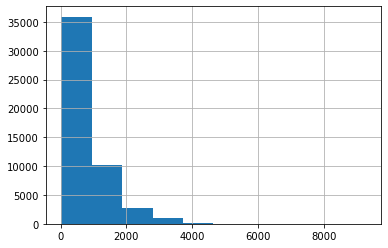

In [7]:
#length of reviews
rev_len = [len(i) for i in list_reviews]
pd.Series(rev_len).hist()
pd.Series(rev_len).describe()

In [20]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

x_train_indices = np.array(x_train)
y_train_indices = np.array(y_train)
x_test_indices = np.array(x_test)
y_test_indices = np.array(y_test)

In [24]:
m = x_train_indices.shape[0]                                   # number of training examples
X_indices = np.zeros((m,1000))

for i in range(2):   
    print("done")                            # loop over training examples
    sentence_words = x_train_indices[i].split()
    j = 0
    for w in sentence_words:
        if j >= 1000:
            break
        # if w exists in the word_to_index dictionary
        if w in list(word_to_index.keys()):
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = word_to_index[w]
            j =  j+1

done
done


In [26]:
X_indices[0].shape

(1000,)

In [30]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)

    """
    
    m = X.shape[0]                                   # number of training examples
    X_indices = np.zeros((m,max_len))
    
    for i in range(m):   # loop over training examples
        print(i)
        sentence_words = X[i].split()
        j = 0
        for w in sentence_words:
            if j >= max_len:
                break
            # if w exists in the word_to_index dictionary
            if w in list(word_to_index.keys()):
                # Set the (i,j)th entry of X_indices to the index of the correct word.
                X_indices[i, j] = word_to_index[w]
                j =  j+1
    
    return X_indices

X_train_indices = sentences_to_indices(x_train_indices, word_to_index, 1000)
X_test_indices = sentences_to_indices(x_test_indices, word_to_index,1000)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [9]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

c:\Users\kando\Desktop\unsw\embedding_utils.py:118: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(final_list_train), np.array(y_train),np.array(final_list_test), np.array(y_val),onehot_dict


In [ ]:
# create Tensor datasets
# train_data = TensorDataset(torch.from_numpy(x_train_indices), torch.from_numpy(y_train))
# valid_data = TensorDataset(torch.from_numpy(x_test_indices), torch.from_numpy(y_test))

train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [ ]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,output_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
        #self.embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=self.hidden_dim,
                           num_layers=no_layers,
                           #bidirectional=True,
                           dropout=drop_prob,
                           batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(drop_prob)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)

        # embeddings and lstm_out
        #embeds = self.embedding_layer(x)
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]

        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        #Initializes hidden state 
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [ ]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 50
output_dim = 1
hidden_dim = 256

model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,output_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1001, 50)
  (lstm): LSTM(50, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [ ]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 0.6013885924021403 val_loss : 0.4429934469461441
train_accuracy : 66.888 val_accuracy : 79.624
Validation loss decreased (inf --> 0.442993).  Saving model ...
Epoch 2
train_loss : 0.4387856602271398 val_loss : 0.37661182594299314
train_accuracy : 80.46933333333334 val_accuracy : 83.64
Validation loss decreased (0.442993 --> 0.376612).  Saving model ...
Epoch 3
train_loss : 0.35976796756188073 val_loss : 0.34479209476709366
train_accuracy : 84.56 val_accuracy : 84.952
Validation loss decreased (0.376612 --> 0.344792).  Saving model ...
Epoch 4
train_loss : 0.3265924266775449 val_loss : 0.33564851409196855
train_accuracy : 86.29866666666666 val_accuracy : 85.392
Validation loss decreased (0.344792 --> 0.335649).  Saving model ...
Epoch 5
train_loss : 0.3016802546083927 val_loss : 0.3278670167326927
train_accuracy : 87.26666666666667 val_accuracy : 85.912
Validation loss decreased (0.335649 --> 0.327867).  Saving model ...


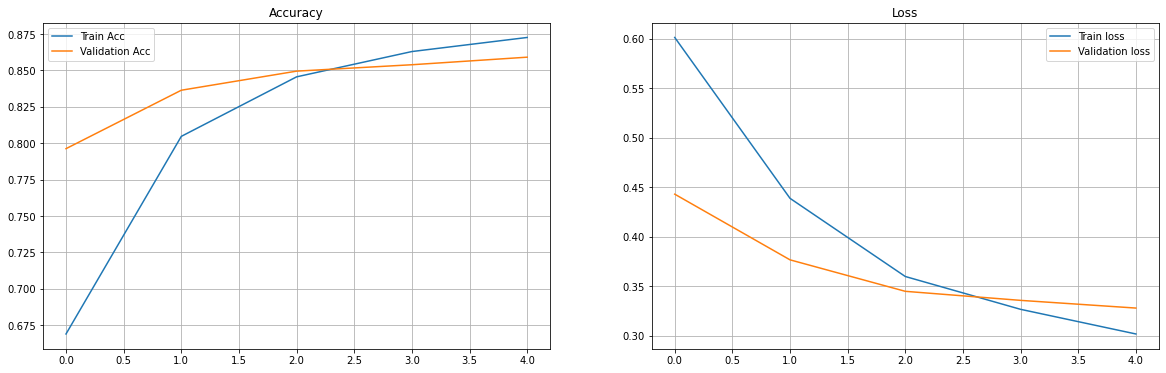

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [22]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_text(word)] for word in text.split() 
                         if preprocess_text(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [29]:
index = 32
print(imdb_data['review'][index])
print('='*70)
if imdb_data["sentiment"][index]:
    act = 'negative'
else:
    act = 'positive'
print(f'Actual sentiment is  : {act}')
print('='*70)
pro = predict_text(imdb_data['review'][index])
status = "positive" if pro < 0.5 else "negative"
pro = 1 - pro if status == "positive" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

first exposure templarios good one excited find title among offerings anchor bay video brought us cult classics spider baby print quality excellent alone cant hide fact film deadly dull theres thrilling opening sequence villagers exact terrible revenge templars set whole thing motion everything else movie slow ponderous ultimately unfulfilling adding insult injury movie dubbed subtitled promised video jacket
Actual sentiment is  : negative
Predicted sentiment is negative with a probability of 0.8399251699447632
